# Objetivo #

El objetivo de este cuaderno es el de determinar la importancia de la cuantización a la hora de detectar imágenes generadas por inteligencia artificial.

# Obtención de los coeficientes #

El primer paso será obtener los coeficientes de cada transformada.


In [2]:
# imports
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import os

In [2]:
# torch configuration
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.set_default_device(device)

Using cuda device


In [1]:
# Constants
EPSILON = 1e-6

In [4]:
#########################
# FFT
#########################

def compute_fft2d(block):
    """
    Compute 2D Fourier Transform using FFT.
    
    Parameters:
    - block (torch.Tensor): input block
    
    Returns:
    - torch.Tensor: Fourier coefficients
    """
    return torch.fft.fft2(block)
    
#########################
# DCT
#########################

def dct_fft_impl(v):
    return torch.view_as_real(torch.fft.fft(v, dim=1))

def dct(x):
    """
    Compute 1D Discrete Cosine Transform (DCT-II) using FFT.
    """
    x_shape = x.shape
    N = x_shape[-1]
    x = x.contiguous().view(-1, N)

    v = torch.cat([x[:, ::2], x[:, 1::2].flip([1])], dim=1)

    Vc = dct_fft_impl(v)

    k = - torch.arange(N, dtype=x.dtype, device=x.device)[None, :] * np.pi / (2 * N)
    W_r = torch.cos(k)
    W_i = torch.sin(k)

    V = Vc[:, :, 0] * W_r - Vc[:, :, 1] * W_i
    V[:, 0] /= np.sqrt(N) * 2 # norm='ortho'
    V[:, 1:] /= np.sqrt(N / 2) * 2 # norm='ortho'

    V = 2 * V.view(*x_shape)

    return V

def compute_dct2d(block):
    """
    Compute DCT of an 8x8 block

    Parameters:
    - block (torch.Tensor): input 8x8 block

    Returns:
    - torch.Tensor: DCT coefficients
    """
    X1 = dct(block)
    X2 = dct(X1.transpose(-1, -2))
    return X2.transpose(-1, -2)

#########################
# DST
#########################

def dst_fft_impl(v):
    return torch.view_as_real(torch.fft.fft(v, dim=1))

def dst(x):
    """
    Compute 1D Discrete Sine Transform (DST) using FFT.
    """
    x_shape = x.shape
    N = x_shape[-1]
    x = x.contiguous().view(-1, N)
    
    v = torch.cat([torch.zeros_like(x[:, :1]), x, -x.flip([1])[:, :-1]], dim=1)
    
    Vc = dst_fft_impl(v)
    
    k = torch.arange(N, dtype=x.dtype, device=x.device)[None, :] * np.pi / (N + 1)
    W_r = torch.sin(k)
    W_i = torch.cos(k)
    
    V = Vc[:, 1:N+1, 0] * W_r + Vc[:, 1:N+1, 1] * W_i
    
    V = 2 * V.view(*x_shape)
    
    return V

def compute_dst2d(block):
    """
    Compute 2D Discrete Sine Transform (DST-II).
    
    Parameters:
    - block (torch.Tensor): input block
    
    Returns:
    - torch.Tensor: DST coefficients
    """
    X1 = dst(block)
    X2 = dst(X1.transpose(-1, -2))
    return X2.transpose(-1, -2)

In [5]:
path = "dummy-images/natural/natural-1.jpg"

# Load image and convert to grayscale
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image = torch.tensor(image, dtype=torch.float, device=device)

fft_image = compute_fft2d(image)
print(fft_image)

dct_image = compute_dct2d(image)
print(dct_image)

dst_image = compute_dst2d(image)
print(dst_image)

print(fft_image.real)
print(fft_image.imag)
print(torch.is_complex(fft_image))

tensor([[ 3.0199e+07+0.0000j, -2.8660e+06+1074676.5000j,
         -1.0814e+05+195810.0938j,  ...,
         -2.9945e+04+1318499.2500j, -1.0814e+05-195810.0625j,
         -2.8660e+06-1074676.2500j],
        [ 2.1035e+06-4028792.5000j,  5.8271e+04+1537176.1250j,
         -2.3963e+05-431822.9375j,  ...,
         -2.1783e+05-570085.1875j,  5.0382e+05+569312.5625j,
          1.9439e+06+1762731.7500j],
        [ 2.9037e+05+241801.3438j, -1.4210e+06-394680.8750j,
         -3.0652e+05+945213.1875j,  ...,
          1.0142e+06-662104.2500j,  2.1887e+05-139844.8281j,
         -6.8968e+05-580299.6250j],
        ...,
        [ 1.3126e+06-142412.1250j,  7.5624e+05-891541.3750j,
          9.4733e+05-493610.2188j,  ...,
         -1.4861e+05+200881.0781j, -4.5558e+05+720734.6875j,
         -1.0456e+05+560353.1250j],
        [ 2.9037e+05-241801.3438j, -6.8968e+05+580299.7500j,
          2.1887e+05+139844.8125j,  ...,
         -1.5846e+04-652420.0000j, -3.0652e+05-945213.0625j,
         -1.4210e+06+394681

# Obtener lista de primeros dígitos #

Dada una matriz de coeficientes, obtener la lista de los primeros dígitos en una base determinada.

In [6]:
def first_significant_digit(values, base):
    """
    Computes the first significant digit (FD) of a given values in a specified base.
    
    Parameters:
    - values (torch.Tensor): coefficient values.
    - base (int): The numerical base.
    
    Returns:
    - torch.Tensor: The first significant digit of the input values in the given base.
    """
    values = torch.flatten(torch.abs(values))

    base = torch.tensor(base, dtype=torch.int32, device=device)
    
    fd = torch.zeros_like(values, dtype=torch.uint8, device=device)
    
    # Select non zero values
    mask = values != 0
    nonzero_values = values[mask]
    
    # Apply the formula only to non zero values
    exponent = torch.floor(torch.log(nonzero_values) / torch.log(base))
    fd_nonzero = torch.floor(nonzero_values / (base ** exponent)).to(torch.uint8)
    
    fd[mask] = fd_nonzero
    
    return fd

In [7]:
fd = first_significant_digit(fft_image, 10)

print(fd)

tensor([3, 3, 2,  ..., 1, 4, 1], device='cuda:0', dtype=torch.uint8)


# PDF para los primeros dígitos #

Calcular la función de densidad de probabilidad para los dígitos anteriormente obtenidos.

In [8]:
def get_pdf_est(digits, base):
    """
    Compute the probability density function of the first significant digits of DCT coefficients.
    
    Parameters:
    - digits (torch.Tensor): First significant digits of DCT coefficients.
    - base (int): Numerical base.
    
    Returns:
    - p_est (dict): Probability density function of the first significant digits of DCT coefficients.
    """
    
    p_est = {i: 0 for i in range(1, base)}

    K = digits.shape[0]

    # Count occurrences of each digit using torch's bincount (efficient counting)
    counts = torch.bincount(digits[digits > 0], minlength=base)[1:]

    # Update p_est with counts
    p_est.update({i: counts[i-1].item() for i in range(1, base)})

    # Compute total non-zero elements (avoid division by zero)
    for i in range(1,base):
        p_est[i] /= K
        if p_est[i] == 0:
            p_est[i] = EPSILON
    
    # Normalize the probabilities
    total = sum(p_est.values())
    for i in range(1, base):
        p_est[i] /= total

    return p_est

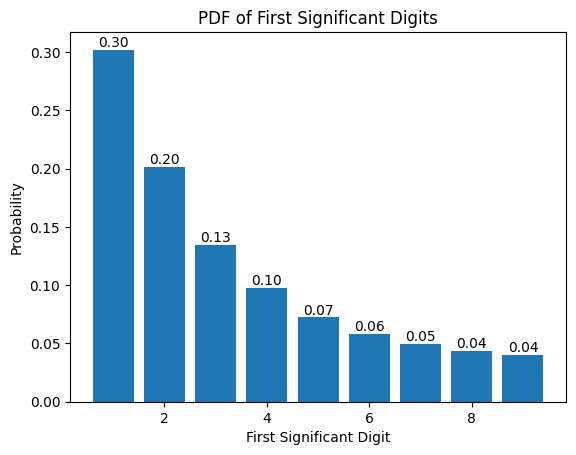

In [9]:
p_est = get_pdf_est(fd, 10)

# Display PDF
bars = plt.bar(p_est.keys(), p_est.values())
plt.xlabel("First Significant Digit")
plt.ylabel("Probability")
plt.title("PDF of First Significant Digits")

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

# Mínimos cuadrados #

Resolver un problema de mínimos cuadrados para comparar la distribución de Benford.

In [10]:
def benford(d, beta, gamma, delta, base):
    """Generalized Benford's Law function."""
    denom = np.clip(gamma + d**delta, EPSILON, None)  # Avoid division by zero
    return beta * (np.log(1 + 1 / denom) / np.log(base))

def residuals(params, d, p):
    """Compute residuals for curve fitting."""
    return benford(d, *params, len(d) + 1) - p

def jacobian(params, d, p):
    beta, gamma, delta = params
    base = len(d) + 1

    J_beta = (np.log(1 - 1 / (gamma - d**delta)) / np.log(base))
    J_gamma = beta / (np.log(base) * (d**delta - gamma) * (d**delta - gamma + 1))
    J_delta = (base * d**delta ** np.log(d)) / (np.log(base) * (d**delta - gamma) * (d**delta - gamma + 1))

    return np.vstack((J_beta, J_gamma, J_delta)).T

def get_pdf_fit(p_est):
    """
    Fit Benford's Law to the estimated probability density function.
    
    Parameters:
    - p_est (dict): Estimated probability density function (keys: digits, values: probabilities).
    
    Returns:
    - p_fit (dict): Fitted probability density function.
    """
    
    p_fit = {}
    
    d_values = np.array(list(p_est.keys()))
    p_values = np.array(list(p_est.values()))

    base = len(d_values) + 1

    initial_guess = [1, 1, 1]

    # popt = opt.least_squares(residuals, initial_guess, jac=jacobian, args=(d_values, p_values))
    popt = opt.least_squares(residuals, initial_guess, args=(d_values, p_values))

    for i in d_values:
        p_fit[i] = benford(i, *popt.x, base)
        if p_fit[i] == 0:
            p_fit[i] = EPSILON  # Avoid division by zero

    # Normalize PDF
    p_fit_sum = sum(p_fit.values())
    for i in d_values:
        p_fit[i] /= p_fit_sum

    return p_fit

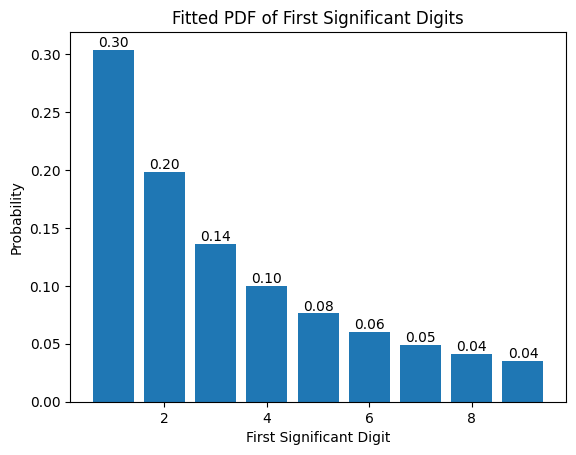

In [11]:
p_fit = get_pdf_fit(p_est)

# Display PDF
bars = plt.bar(p_fit.keys(), p_fit.values())
plt.xlabel("First Significant Digit")
plt.ylabel("Probability")
plt.title("Fitted PDF of First Significant Digits")

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

# Divergencias #

Divergencias para comparar las distribuciones.

In [12]:
def js_divergence(p, q):
    """
    Compute the Jensen-Shannon divergence between two probability distributions.
    
    Parameters:
    - p (dict): First probability distribution.
    - q (dict): Second probability distribution.
    
    Returns:
    - float: Jensen-Shannon divergence between p and q.
    """
    
    return kl_divergence(p, q) + kl_divergence(q, p)

def kl_divergence(p, q):
    """
    Compute the Kullback-Leibler divergence between two probability distributions.
    
    Parameters:
    - p (dict): First probability distribution.
    - q (dict): Second probability distribution.
    
    Returns:
    - float: Kullback-Leibler divergence between p and q.
    """
    
    kl = 0
    
    for key in p.keys():
        kl += p[key] * np.log(p[key] / q[key])
    
    return kl

def r_divergence(p, q, alpha):
    """
    Compute the Renyi divergence between two probability distributions.
    
    Parameters:
    - p (dict): First probability distribution.
    - q (dict): Second probability distribution.
    
    Returns:
    - float: Renyi divergence between p and q.
    """
    
    r = 1 / (1 - alpha) * (np.log(s_function(p, q, alpha)) + np.log(s_function(q, p, alpha)))
    
    return r

def t_divergence(p, q, alpha):
    """
    Compute the Tsallis divergence between two probability distributions.
    
    Parameters:
    - p (dict): First probability distribution.
    - q (dict): Second probability distribution.
    
    Returns:
    - float: Tsallis divergence between p and q.
    """
    
    t = 1 / (1 - alpha) * (2 - s_function(p, q, alpha) - s_function(q, p, alpha))
    
    return t

def s_function(q, p, alpha):
    """
    Compute weighted sum that combines two probability distributions

    Parameters:
    - q (dict): First probability distribution.
    - p (dict): Second probability distribution.
    - alpha (float): Weighting factor.

    Returns:
    - float: Weighted sum of the two probability distributions.
    """

    s = 0

    for key in q.keys():
        s += (q[key] ** alpha) / (p[key] ** (alpha - 1))

    return s

# Vector de característcas #

Por cada imagen, se obtendrán los coeficientes correspondientes a las transformadas de Fourier, del seno y del coseno y se compararán la distribución obtenida de los primeros dígitos (con diferentes bases) de los coeficientes obtenidos con la distribución ajustada correspondiente a la ley general de Benford. Por cada imagen, el vector final tendrá tamaño: $ |B| \times 9 $, donde $|B|$ es el número de bases que se empleen.


In [13]:
def get_feature_vector(image, bases):
    """
    Compute feature vectors of an image
    
    Parameters:
    - image (torch.Tensor): input image
    - bases (list): list of numerical bases
    
    Returns:
    - torch.Tensor: feature vectors
    """

    fft = compute_fft2d(image)
    dst = compute_dst2d(image)
    dct = compute_dct2d(image)

    feature_vectors = torch.zeros((len(bases), 9), dtype=torch.float32, device=device)

    for b, base in enumerate(bases):
        fd_fft = first_significant_digit(fft, base)
        fd_dst = first_significant_digit(dst, base)
        fd_dct = first_significant_digit(dct, base)
        
        p_est_fft = get_pdf_est(fd_fft, base)
        p_fit_fft = get_pdf_fit(p_est_fft)

        p_est_dst = get_pdf_est(fd_dst, base)
        p_fit_dst = get_pdf_fit(p_est_dst)

        p_est_dct = get_pdf_est(fd_dct, base)
        p_fit_dct = get_pdf_fit(p_est_dct)
        
        js_fft = js_divergence(p_est_fft, p_fit_fft)
        r_fft = r_divergence(p_est_fft, p_fit_fft, 0.5)
        t_fft = t_divergence(p_est_fft, p_fit_fft, 0.5)
        js_dst = js_divergence(p_est_dst, p_fit_dst)
        r_dst = r_divergence(p_est_dst, p_fit_dst, 0.5)
        t_dst = t_divergence(p_est_dst, p_fit_dst, 0.5)
        js_dct = js_divergence(p_est_dct, p_fit_dct)
        r_dct = r_divergence(p_est_dct, p_fit_dct, 0.5)
        t_dct = t_divergence(p_est_dct, p_fit_dct, 0.5)
        feature_vectors[b] = torch.tensor([js_fft,r_fft,t_fft,js_dst,r_dst,t_dst,js_dct,r_dct,t_dct], device=device)
    
    return feature_vectors 
    

In [14]:
bases = [10,20,40]

feature_vectors = get_feature_vector(image, bases)

print(feature_vectors)

tensor([[ 1.2790e-03, -6.3939e-04,  6.3934e-04,  2.6366e-05, -1.3183e-05,
          1.3183e-05,  3.7144e-04, -1.8572e-04,  1.8572e-04],
        [ 1.0610e-02, -5.3061e-03,  5.3025e-03,  1.4139e-04, -7.0691e-05,
          7.0690e-05,  1.8848e-03, -9.4243e-04,  9.4232e-04],
        [ 1.6297e-01, -8.0199e-02,  7.9400e-02,  1.0490e-03, -5.2447e-04,
          5.2444e-04,  1.9286e-03, -9.6394e-04,  9.6382e-04]], device='cuda:0')


# Conseguir dataset #

Guardar en un csv el vector de características de todas las imágenes de un directorio.


In [17]:
def process_and_save_images(folder_path, n_images, label, bases, filename):
    """
    Process and save feature vectors of a set of images to a CSV file one by one.

    Parameters:
    - folder_path (str): path to the folder containing the images.
    - n_images (int): number of images to process.
    - label (int): label of the images (1 if AI generated, 0 if not).
    - bases (list): list of numerical bases.
    - filename (str): name of the CSV file.
    """
    # Get the image filenames
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
    n_images = min(n_images, len(image_files))

    if n_images == 0:
        print("No images found in the specified folder.")
        return

    for i in range(n_images):
        image_path = os.path.join(folder_path, image_files[i])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Error loading image: {image_path}")
            continue

        image = torch.tensor(image, dtype=torch.float, device=device)

        try:
            # Extract features
            features = get_feature_vector(image, bases)
        except Exception as e:
            print(f"Error processing image: {image_path}, Error: {e}")
            continue

        # Convert to NumPy and flatten
        flattened_features = features.cpu().numpy().flatten()
        row = np.append(flattened_features, label)

        # Convert to DataFrame and save immediately
        df = pd.DataFrame([row])
        df.to_csv(filename, mode='a', header=not os.path.exists(filename), index=False)

    print(f"{n_images} images have been processed and saved to {filename}")


def generate_csv_header(transformations, divergences, bases, filename):
    """
    Generate and save CSV header based on provided lists.
    """
    
    header = []

    for b in bases:
        for t in transformations:
            for d in divergences:
                    header.append(f"{b}_{t}_{d}")

    header.append("label")

    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)

        if list(df_existing.columns) != header:
            df_existing.columns = header
            df_existing.to_csv(filename, index=False, header=True)  # Sobrescribir con nuevo encabezado
    else:
        df = pd.DataFrame(columns=header)
        df.to_csv(filename, index=False, header=True)
        
    return header

In [18]:
divergences_str = ["js", "r", "t"]
bases_str = ["10", "20", "40"]
transformations_str = ["fft", "dst", "dct"]
filename = "features-no-quant.csv"

csv_header = generate_csv_header(transformations_str, divergences_str, bases_str, filename)

In [16]:
ruta_natural = "dummy-images/natural"
ruta_ia = "dummy-images/ia"

process_and_save_images(ruta_natural, 10, '0', bases, "features-no-quant.csv")
process_and_save_images(ruta_ia, 10, '1', bases, "features-no-quant.csv")

4 images have been processed and saved to features-no-quant.csv
3 images have been processed and saved to features-no-quant.csv
